In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

 # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unseen-for-test-1/a3_IMDb_Unseen_Reviews.csv
/kaggle/input/work-files-for-shobh/a2_glove.6B.100d.txt
/kaggle/input/work-files-for-shobh/IMDB Dataset.csv


In [2]:
#importing all the libraries which will be used in the solution
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

2024-07-31 12:18:16.829247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 12:18:16.829351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 12:18:17.102022: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#reading and storing the dataset
movie = pd.read_csv("/kaggle/input/work-files-for-shobh/IMDB Dataset.csv")

In [4]:
#how many Rows and Column
movie.shape

(50000, 2)

In [5]:
movie.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<Axes: xlabel='sentiment', ylabel='count'>

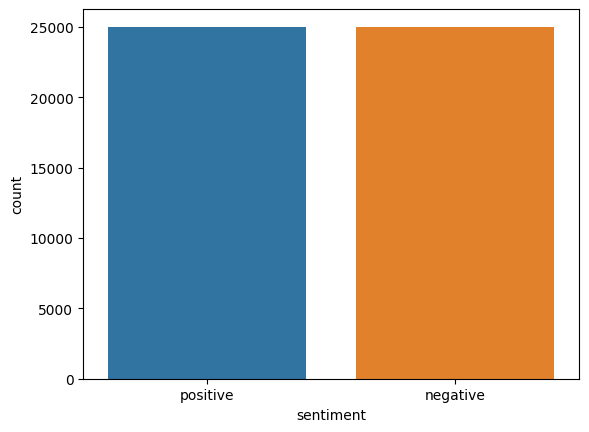

In [6]:
# Counting the number of Sentinments 
import seaborn as sns
sns.countplot(x='sentiment', data=movie)

In [7]:
#randomly taking a review 
movie["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [8]:
# Function to remove the Html tags
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [9]:
#check for latest update in stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [11]:
X = []
sentences = list(movie['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [12]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [13]:
y = movie['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [14]:
#Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [15]:
#Convert words to integers
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [16]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [17]:
#padding the sequence to make all the reviews uniform
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
#store the embedding in Dictionary form
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/kaggle/input/work-files-for-shobh/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [19]:
#create an embedding matrix 
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [20]:
embedding_matrix.shape

(92394, 100)

In [21]:
# Initialize a sequential model
## Add the embedding layer to the model
# vocab_length: size of the vocabulary
# 100: size of the GloVe vectors
# weights: use the pre-trained embedding matrix
# input_length: maximum length of the input sequences
# trainable=False: the embedding layer weights are not trainable
from keras.layers import Conv1D
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.build(input_shape=(None, maxlen))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
#compile the model and print it's summary before running
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,303,657 (35.49 MB)

 Trainable params: 64,257 (251.00 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [23]:
#fit the model over desired batch_size and epochs 
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.25)

Epoch 1/6
 62/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6256 - loss: 0.6362

I0000 00:00:1722428375.437016      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - acc: 0.7155 - loss: 0.5440 - val_acc: 0.8349 - val_loss: 0.3795
Epoch 2/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8559 - loss: 0.3407 - val_acc: 0.8428 - val_loss: 0.3524
Epoch 3/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8894 - loss: 0.2865 - val_acc: 0.8365 - val_loss: 0.3692
Epoch 4/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9101 - loss: 0.2451 - val_acc: 0.8522 - val_loss: 0.3343
Epoch 5/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9345 - loss: 0.1990 - val_acc: 0.8577 - val_loss: 0.3299
Epoch 6/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9571 - loss: 0.1594 - val_acc: 0.8553 - val_loss: 0.3360


In [24]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8594 - loss: 0.3355


In [25]:
#check the score and the accuracy 
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33585843443870544
Test Accuracy: 0.85589998960495


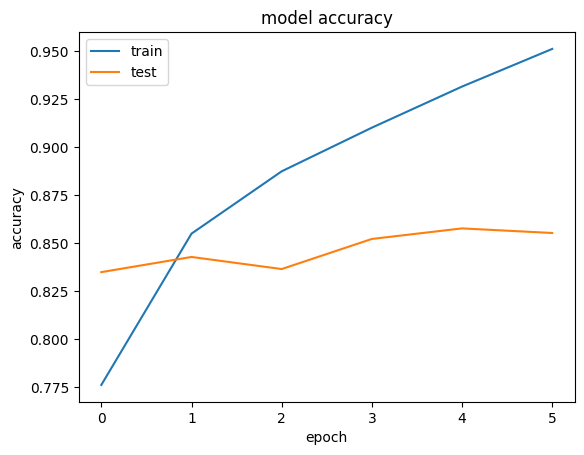

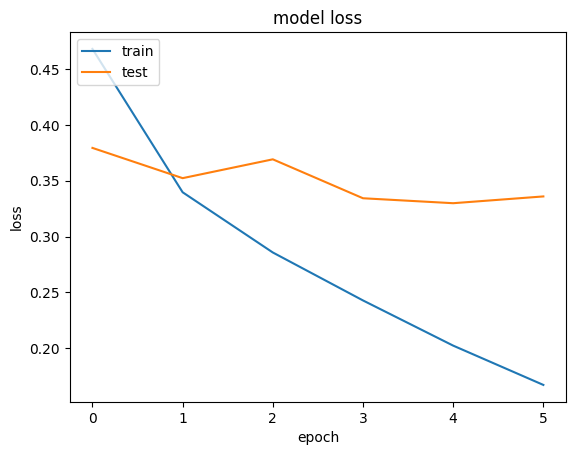

In [26]:

#plot model's accuracy and loss in training to testing graphs
import matplotlib.pyplot as plt


plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [28]:
#import LSTM from keras
from keras.layers import LSTM

In [29]:
#Similar to CNN use Sigmoid for 0&1 classification over sentiments
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.build(input_shape=(None, maxlen))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,356,777 (35.69 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [30]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.20)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - acc: 0.6793 - loss: 0.5816 - val_acc: 0.8000 - val_loss: 0.4623
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8028 - loss: 0.4372 - val_acc: 0.8305 - val_loss: 0.4054
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.8353 - loss: 0.3797 - val_acc: 0.8386 - val_loss: 0.3801
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.8526 - loss: 0.3509 - val_acc: 0.8453 - val_loss: 0.3540
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.8638 - loss: 0.3239 - val_acc: 0.8566 - val_loss: 0.3345
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.8740 - loss: 0.3037 - val_acc: 0.8668 - val_loss: 0.3558


In [31]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8631 - loss: 0.3603


In [32]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


Test Score: 0.3645172715187073
Test Accuracy: 0.86080002784729


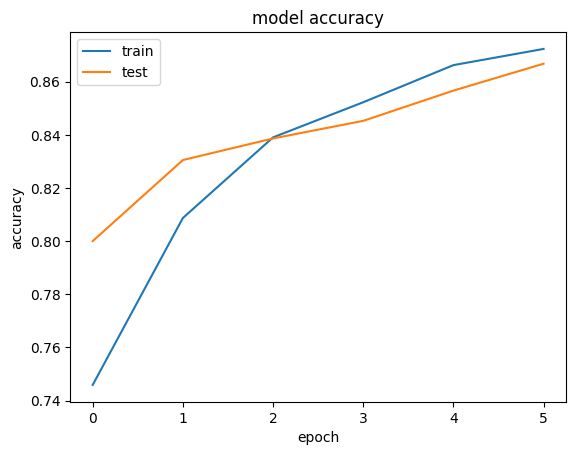

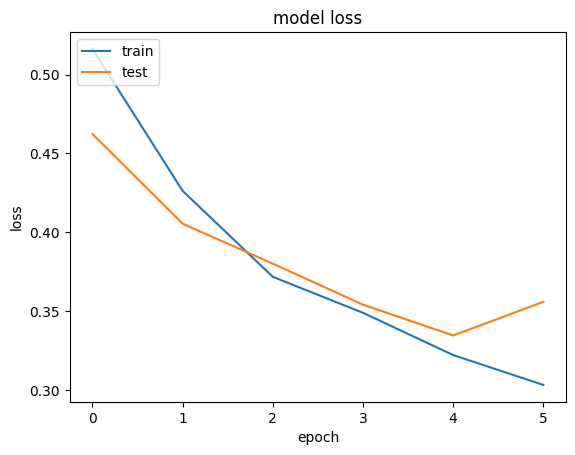

In [33]:
#plot the graph to check for overfitting 
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
#the model turns to generalise well 

In [44]:
#test the model,call the unseen review' datset
test_review=pd.read_csv("/kaggle/input/unseen-for-test-1/a3_IMDb_Unseen_Reviews.csv")
test_review.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [45]:
#Filter and Tokenize as done for the traning data
unseen_reviews = test_review['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [46]:
#feed the data to the model 
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[0.88433254],
       [0.97331816],
       [0.08877465],
       [0.34926233],
       [0.9740408 ],
       [0.02270294]], dtype=float32)

In [47]:

test_review['Predicted Sentiments'] = np.round(unseen_sentiments * 10, 1)#convert the predicted sentiment on 10 scale


df_prediction_sentiments = pd.DataFrame(test_review['Predicted Sentiments'], columns=['Predicted Sentiments'])
df_movie = pd.DataFrame(test_review['Movie'], columns=['Movie'])
df_review_text = pd.DataFrame(test_review['Review Text'], columns=['Review Text'])
df_imdb_rating = pd.DataFrame(test_review['IMDb Rating'], columns=['IMDb Rating'])

#add an extra column of predicted values to the dataset
dfx = pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.8
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.7
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.9
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,3.5
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.7
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.2
